In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 38.6 MB/s eta 0:00:00


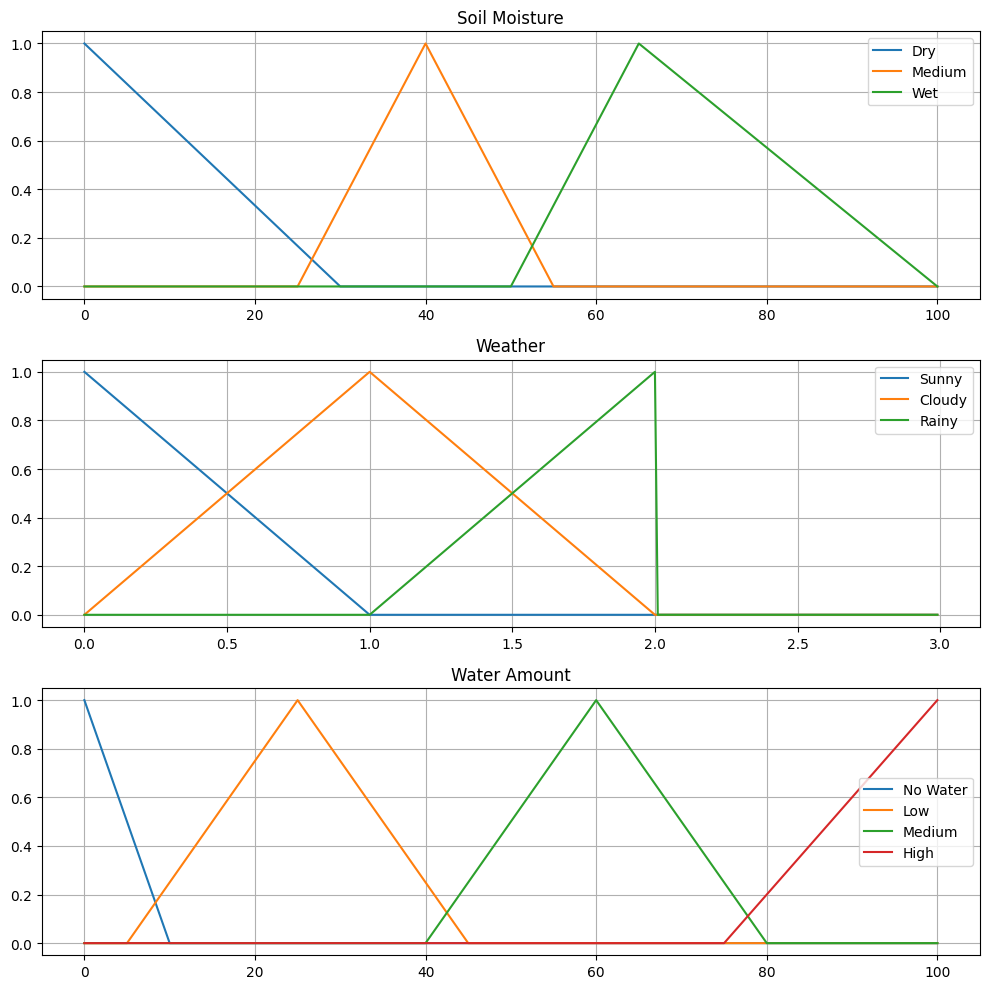


Daily Simulation Report:

Day 1:
  Weather: Cloudy ☁️
  Soil Moisture Before: 40.00%
  Activated Rule: Rule 5
  Defuzzified Outputs:
    - Centroid: 25.00
    - Mean of Max (MoM): 25.00
    - Smallest of Max (SoM): 25.00
    - Bisector: 25.00
  Water Given (simulation): 25.00 units
----------------------------------------
Day 2:
  Weather: Sunny ☀️
  Soil Moisture Before: 39.20%
  Activated Rule: Rule 4
  Defuzzified Outputs:
    - Centroid: 60.00
    - Mean of Max (MoM): 60.00
    - Smallest of Max (SoM): 60.00
    - Bisector: 60.00
  Water Given (simulation): 60.00 units
----------------------------------------
Day 3:
  Weather: Cloudy ☁️
  Soil Moisture Before: 37.12%
  Activated Rule: Rule 5
  Defuzzified Outputs:
    - Centroid: 25.00
    - Mean of Max (MoM): 25.00
    - Smallest of Max (SoM): 25.00
    - Bisector: 25.00
  Water Given (simulation): 25.00 units
----------------------------------------
Day 4:
  Weather: Cloudy ☁️
  Soil Moisture Before: 36.38%
  Activated Rule: Rul

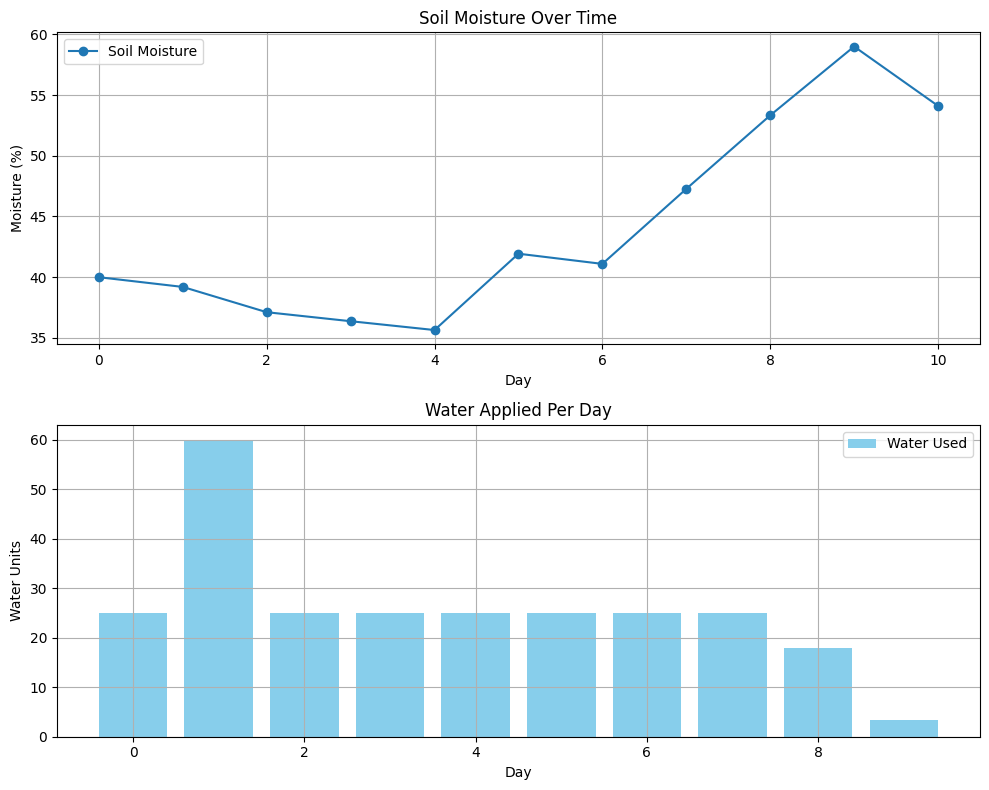

In [14]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import random

# =======================
# Step 1: Define Membership Functions
# =======================

soil_moisture = np.arange(0, 101, 1)
soil_moisture_dry = fuzz.trimf(soil_moisture, [0, 0, 30])
soil_moisture_medium = fuzz.trimf(soil_moisture, [25, 40, 55])
soil_moisture_wet = fuzz.trimf(soil_moisture, [50, 65, 100])

weather = np.arange(0, 3, 0.01)
weather_sunny = fuzz.trimf(weather, [0, 0, 1])
weather_cloudy = fuzz.trimf(weather, [0, 1, 2])
weather_rainy = fuzz.trimf(weather, [1, 2, 2])

water = np.arange(0, 101, 1)
water_none = fuzz.trimf(water, [0, 0, 10])
water_low = fuzz.trimf(water, [5, 25, 45])
water_medium = fuzz.trimf(water, [40, 60, 80])
water_high = fuzz.trimf(water, [75, 100, 100])

# Plotting
fig, axs = plt.subplots(nrows=3, figsize=(10, 10))

axs[0].plot(soil_moisture, soil_moisture_dry, label='Dry')
axs[0].plot(soil_moisture, soil_moisture_medium, label='Medium')
axs[0].plot(soil_moisture, soil_moisture_wet, label='Wet')
axs[0].set_title('Soil Moisture')
axs[0].legend()

axs[1].plot(weather, weather_sunny, label='Sunny')
axs[1].plot(weather, weather_cloudy, label='Cloudy')
axs[1].plot(weather, weather_rainy, label='Rainy')
axs[1].set_title('Weather')
axs[1].legend()

axs[2].plot(water, water_none, label='No Water')
axs[2].plot(water, water_low, label='Low')
axs[2].plot(water, water_medium, label='Medium')
axs[2].plot(water, water_high, label='High')
axs[2].set_title('Water Amount')
axs[2].legend()

for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()

# =======================
# Step 2: Fuzzy Inference Function
# =======================

def fuzzy_inference(soil_value, weather_value):
    dry = fuzz.interp_membership(soil_moisture, soil_moisture_dry, soil_value)
    medium = fuzz.interp_membership(soil_moisture, soil_moisture_medium, soil_value)
    wet = fuzz.interp_membership(soil_moisture, soil_moisture_wet, soil_value)

    sunny = fuzz.interp_membership(weather, weather_sunny, weather_value)
    cloudy = fuzz.interp_membership(weather, weather_cloudy, weather_value)
    rainy = fuzz.interp_membership(weather, weather_rainy, weather_value)

    # Apply rules
    rule1 = np.fmin(dry, sunny)
    rule2 = np.fmin(dry, cloudy)
    rule3 = np.fmin(dry, rainy)
    rule4 = np.fmin(medium, sunny)
    rule5 = np.fmin(medium, cloudy)
    rule6 = np.fmin(medium, rainy)
    rule7 = np.fmin(wet, sunny)
    rule8 = np.fmin(wet, cloudy)
    rule9 = np.fmin(wet, rainy)

    rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
    rule_activations = np.array([np.max(r) for r in rules])
    active_rule = np.argmax(rule_activations) + 1

    activation_high = np.fmax(rule1, np.zeros_like(water))
    activation_medium = np.fmax(rule2, rule4)
    activation_low = np.fmax(rule3, np.fmax(rule5, rule6))
    activation_none = np.fmax(rule7, np.fmax(rule8, rule9))

    aggregated = np.fmax(
        np.fmax(activation_none * water_none, activation_low * water_low),
        np.fmax(activation_medium * water_medium, activation_high * water_high)
    )

    # Defuzzification with multiple methods
    centroid = fuzz.defuzz(water, aggregated, 'centroid')
    mom = fuzz.defuzz(water, aggregated, 'mom')
    som = fuzz.defuzz(water, aggregated, 'som')
    bisector = fuzz.defuzz(water, aggregated, 'bisector')

    return centroid, mom, som, bisector, active_rule

# =======================
# Step 3: Simulation
# =======================

def time_simulation(initial_soil_moisture, weather_list):
    efficiency = 0.8
    max_effective_water = 10
    moisture_log = [initial_soil_moisture]
    water_log = []
    rule_log = []

    soil = initial_soil_moisture

    print("\nDaily Simulation Report:\n")

    for day, weather_today in enumerate(weather_list):
        centroid, mom, som, bisector, rule_used = fuzzy_inference(soil, weather_today)

        # Use centroid output for simulation
        water_amount = centroid

        # Apply weather effect
        if weather_today == 0:
            effect = -5
        elif weather_today == 1:
            effect = -2
        else:
            effect = +5

        water_amount_norm = (water_amount / 100) * max_effective_water
        gain = water_amount_norm * (1 - (soil / 100)) * efficiency
        soil = max(0, min(100, soil + gain + effect))

        moisture_log.append(soil)
        water_log.append(water_amount)
        rule_log.append(rule_used)

        # Print full results
        weather_names = {0: "Sunny ☀️", 1: "Cloudy ☁️", 2: "Rainy 🌧️"}
        print(f"Day {day+1}:")
        print(f"  Weather: {weather_names[weather_today]}")
        print(f"  Soil Moisture Before: {moisture_log[-2]:.2f}%")
        print(f"  Activated Rule: Rule {rule_used}")
        print(f"  Defuzzified Outputs:")
        print(f"    - Centroid: {centroid:.2f}")
        print(f"    - Mean of Max (MoM): {mom:.2f}")
        print(f"    - Smallest of Max (SoM): {som:.2f}")
        print(f"    - Bisector: {bisector:.2f}")
        print(f"  Water Given (simulation): {water_amount:.2f} units")
        print("-" * 40)

    return moisture_log, water_log, rule_log

# =======================
# Step 4: Run the simulation
# =======================

initial_moisture = 40
weather_list = random.choices([0, 1, 2], k=10)
moisture, water_used, rules = time_simulation(initial_moisture, weather_list)


# =======================
# Step 5: Plotting
# =======================

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(range(len(moisture)), moisture, marker='o', label='Soil Moisture')
axs[0].set_title('Soil Moisture Over Time')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Moisture (%)')
axs[0].grid(True)
axs[0].legend()

axs[1].bar(range(10), water_used, color='skyblue', label='Water Used')
axs[1].set_title('Water Applied Per Day')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Water Units')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()
